In [51]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.linalg import lu_factor, lu_solve
from scipy.optimize import minimize, newton

import cvxpy as cvx

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(color_codes=True)

from tqdm import tqdm

In [2]:
%matplotlib notebook

In [3]:
def generate_gaussian(N, D, seed=0):
    np.random.seed(seed)
    X = np.random.normal(0, 1, (N, D))
    y = (np.random.normal(0, 1, N) > 0) * 2.0 - 1.0
    return X, y

def generate_gaussian_mixture(N, D, separation=1, offset=0, seed=0):
    assert(N % 2 == 0)
    np.random.seed(seed)
    Xp = np.random.normal(0, 1, (N // 2, D))
    Xp[:, 0] += separation / 2 + offset
    Xn = np.random.normal(0, 1, (N // 2, D))
    Xn[:, 0] += -separation / 2 + offset
    X = np.vstack((Xp, Xn))
    y = np.hstack((np.full(N // 2, 1), np.full(N // 2, -1)))
    return X, y

In [4]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def optimize_direct_bfgs(X, y):
    def objective(theta):
        return -np.mean(np.log(sigmoid(y * np.dot(X, theta))))
    res = minimize(objective, np.zeros(X.shape[1]), method='BFGS', tol=1e-8)
    return res.x

def optimize_sklearn(X, y):
    model = LogisticRegression(C=1e8, fit_intercept=False, solver='liblinear', tol=1e-8)
    model.fit(X, y)
    return model.coef_.reshape(-1)

# Training and influence prediction procedure

In [69]:
def losses_and_hessian(X, y, theta):
    sigmoids = sigmoid(y * np.dot(X, theta))
    L_1 = -y * (1 - sigmoids)
    L_2 = sigmoids * (1 - sigmoids)
    L_3 = y * sigmoids * (1 - sigmoids) * (1 - 2 * sigmoids)
    H = np.dot(X.T * L_2, X) / X.shape[0]
    return sigmoids, L_1, L_2, L_3, H

def train(X, y, indices=None, X_test=None, y_test=None):
    """
    Trains a binary logistic regression model, outputting the test loss
    and test loss gradient as well as the influence of selected training points.
    """
    theta = optimize_sklearn(X, y)

    sigmoids, L_1, L_2, L_3, H = losses_and_hessian(X, y, theta)
    lu, piv = lu_factor(H)

    IF_1, IF_2 = None, None
    if indices is not None:
        EC_0 = np.sum(X[indices].T * L_1[indices], axis=1)
        IF_1 = -lu_solve((lu, piv), EC_0)
        D_1 = np.dot(X, IF_1.T)
        AB_2 = np.mean(X.T * L_3 * (D_1 ** 2), axis=1)
        EC_1 = np.sum(X[indices].T * (L_2[indices] * D_1[indices]), axis=1)
        IF_2 = -lu_solve((lu, piv), AB_2 + 2 * EC_1)

    L_test, grad_L_test = None, None
    if X_test is not None and y_test is not None:
        sigmoids_test = sigmoid(y_test * np.dot(X_test, theta))
        L_test = -np.log(sigmoids_test)
        grad_L_test = -(y_test * (1 - sigmoids_test))[:, np.newaxis] * X_test

    return L_test, grad_L_test, IF_1, IF_2, theta

def train_external(X, y, X_infl=None, y_infl=None, X_test=None, y_test=None):
    """
    Trains a binary logistic regression model, outputting the test loss
    and test loss gradient as well as the influence of selected training points.
    """
    theta = optimize_direct_bfgs(X, y)

    sigmoids, L_1, L_2, L_3, H = losses_and_hessian(X, y, theta)
    lu, piv = lu_factor(H)
    
    IF_1, IF_2 = None, None
    if X_infl is not None and y_infl is not None:
        sigmoids_infl, L_infl_1, L_infl_2, _, _ = losses_and_hessian(X_infl, y_infl, theta)

        EC_0 = np.sum(X_infl.T * L_infl_1, axis=1)
        IF_1 = -lu_solve((lu, piv), EC_0)
        D_1 = np.dot(X, IF_1.T)
        D_infl_1 = np.dot(X_infl, IF_1.T)
        AB_2 = np.mean(X.T * L_3 * (D_1 ** 2), axis=1)
        EC_1 = np.sum(X_infl.T * (L_infl_2 * D_infl_1), axis=1)
        IF_2 = -lu_solve((lu, piv), AB_2 + 2 * EC_1)

    L_test, grad_L_test = None, None
    if X_test is not None and y_test is not None:
        sigmoids_test = sigmoid(y_test * np.dot(X_test, theta))
        L_test = -np.log(sigmoids_test)
        grad_L_test = -(y_test * (1 - sigmoids_test))[:, np.newaxis] * X_test

    return L_test, grad_L_test, IF_1, IF_2, theta

def train_external_indiv(X, y, X_infl=None, y_infl=None, X_test=None, y_test=None):
    """
    Trains a binary logistic regression model, outputting the test loss
    and test loss gradient, but outputs the individual influence of selected training points
    instead of their total influence.
    """
    n, d = X.shape
    theta = optimize_direct_bfgs(X, y)

    sigmoids = sigmoid(y * np.dot(X, theta))
    L_1 = -y * (1 - sigmoids)
    L_2 = sigmoids * (1 - sigmoids)
    L_3 = y * sigmoids * (1 - sigmoids) * (1 - 2 * sigmoids)

    H = np.dot(X.T * L_2, X) / n
    lu, piv = lu_factor(H)
    
    IF_1, IF_2 = None, None
    if X_infl is not None and y_infl is not None:
        sigmoids_infl, L_infl_1, L_infl_2, _, _ = losses_and_hessian(X_infl, y_infl, theta)

        EC_0 = X_infl.T * L_infl_1
        IF_1 = -lu_solve((lu, piv), EC_0)
        D_1 = np.dot(X, IF_1)
        D_infl_1 = np.sum(X_infl * IF_1.T, axis=1)
        AB_2 = np.mean((X.T * L_3)[:, :, np.newaxis] * (D_1 ** 2), axis=1)
        EC_1 = X_infl.T * (L_infl_2 * D_infl_1)
        IF_2 = -lu_solve((lu, piv), AB_2 + 2 * EC_1)

    L_test, grad_L_test = None, None
    if X_test is not None and y_test is not None:
        sigmoids_test = sigmoid(y_test * np.dot(X_test, theta))
        L_test = -np.log(sigmoids_test)
        grad_L_test = -(y_test * (1 - sigmoids_test))[:, np.newaxis] * X_test

    return L_test, grad_L_test, IF_1, IF_2, theta

def predict_influence(eps, grad_L_test, IF_1, IF_2):
    order_1 = np.dot(grad_L_test, IF_1) * eps
    order_2 = order_1 + np.dot(grad_L_test, IF_2) * eps * eps / 2.0
    return order_1, order_2

# Plot error in 2D

If we restrict the problem to the influence of a given point x with respect to the model's prediction on x, how do the gradient norms, first order influence and approximation error vary over the training space?

In [40]:
def self_influence(X, y, X_sample, y_sample):
    """
    Computes actual/predicted self-influence, gradients for each point in x_sample.
    """
    N, D = X.shape
    N_infl = X_sample.shape[0]
    orig_L_test, grad_L_test, IF_1, IF_2, _ = train_external_indiv(
        X, y, X_sample, y_sample, X_sample, y_sample)
    
    I_actual, I_order_1, I_order_2 = [], [], []
    for i in range(N_infl):
        Xp = np.vstack((X, X_sample[i]))
        yp = np.hstack((y, y_sample[i]))
        L_test, _, _, _, _ = train(Xp, yp, None, [X_sample[i]], [y_sample[i]])
        
        eps = 1.0 / N
        order_1, order_2 = predict_influence(eps, grad_L_test[i, :], IF_1[:, i], IF_2[:, i])
        
        I_actual.append(np.sum(L_test) - orig_L_test[i])
        I_order_1.append(order_1)
        I_order_2.append(order_2)
    
    return np.array(I_actual), np.array(I_order_1), np.array(I_order_2), grad_L_test

In [41]:
def sample_line(X, y, X_0=None, X_1=None, line_samples=100, radius=None):
    N, D = X.shape
    
    # Default to picking a line segment of length 2 * radius crossing the origin
    if X_0 is None or X_1 is None:
        radius = 5.0 if radius is None else radius
        X_0 = np.random.normal(0, 1, (D,))
        X_0 = X_0 / np.linalg.norm(X_0) * radius
        X_1 = -X_0
        
    # Generate line_samples points between X_0 and X_1 in the positive class
    X_sample = X_0 + np.linspace(0, 1, 100).reshape(-1, 1) * (X_1 - X_0)
    y_sample = np.full(X_sample.shape[0], 1)
    samples = self_influence(X, y, X_sample, y_sample)
    
    return X_sample, y_sample, samples

In [42]:
def plot_variation_2d(X, y, X_sample, y_sample, samples):
    I_actual, I_order_1, I_order_2, grad_L_sample = samples
    line = np.array([X_sample[0], X_sample[-1]])
    t_sample = np.linspace(0, 1, X_sample.shape[0])
    
    fig, axs = plt.subplots(2, 2, figsize=(9,9))
    
    def plot_dataset(ax):
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.get_cmap('bwr'), s=2)
        ax.plot(line[:, 0], line[:, 1], 'go-')
        ax.annotate('t=0', line[0])
        ax.annotate('t=1', line[1])
        ax.set_title('Dataset')
    
    def plot_influences(ax):
        ax.plot(t_sample, I_actual, label='I_actual')
        ax.plot(t_sample, I_order_1, label='I_order_1')
        #ax.plot(t_sample, I_order_2, label='I_order_2')
        ax.set_title('Influence')
        ax.set_xlabel('t')
        ax.legend()
    
    def plot_approx_error(ax):
        ax.plot(t_sample, I_order_1 - I_actual, label='I_order_1 - I_actual')
        #ax.plot(t_sample, I_order_2 - I_actual, label='I_order_2 - I_actual')
        ax.plot(t_sample, np.abs(I_order_1 - I_actual) / (np.abs(I_actual) + 1e-9), label='(I_order_1 - I_actual) / I_actual')
        ax.set_title('Approximation error')
        ax.set_xlabel('t')
        ax.legend()
    
    def plot_grad_L(ax):
        ax.plot(t_sample, np.linalg.norm(grad_L_sample, axis=1), 'g-', linewidth=2)
        ax.set_title('grad_L norm plot')
        ax.set_xlabel('t')
    
    plot_dataset(axs[0][0])
    plot_influences(axs[0][1])
    plot_approx_error(axs[1][0])
    plot_grad_L(axs[1][1])
    plt.tight_layout()

In [43]:
X, y = generate_gaussian_mixture(200, 2)

<IPython.core.display.Javascript object>


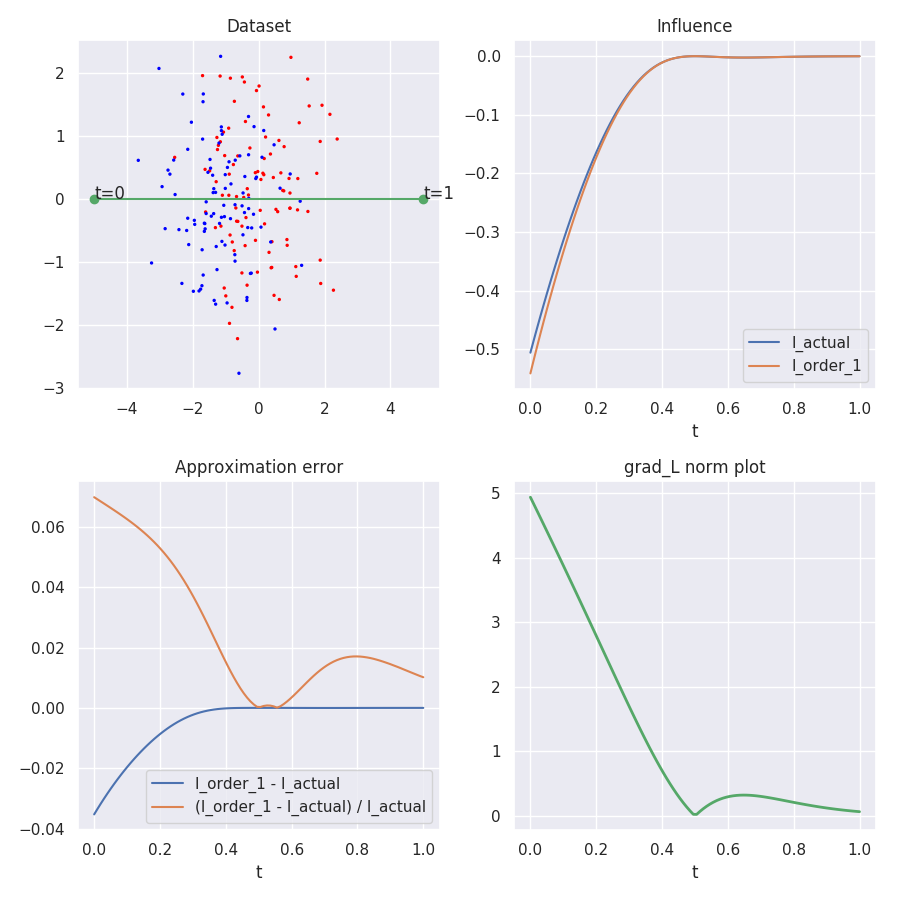

In [44]:
X_0, X_1 = np.array([-5, 0]), np.array([5, 0])
X_sample, y_sample, samples = sample_line(X, y, X_0, X_1)
plot_variation_2d(X, y, X_sample, y_sample, samples)

<IPython.core.display.Javascript object>


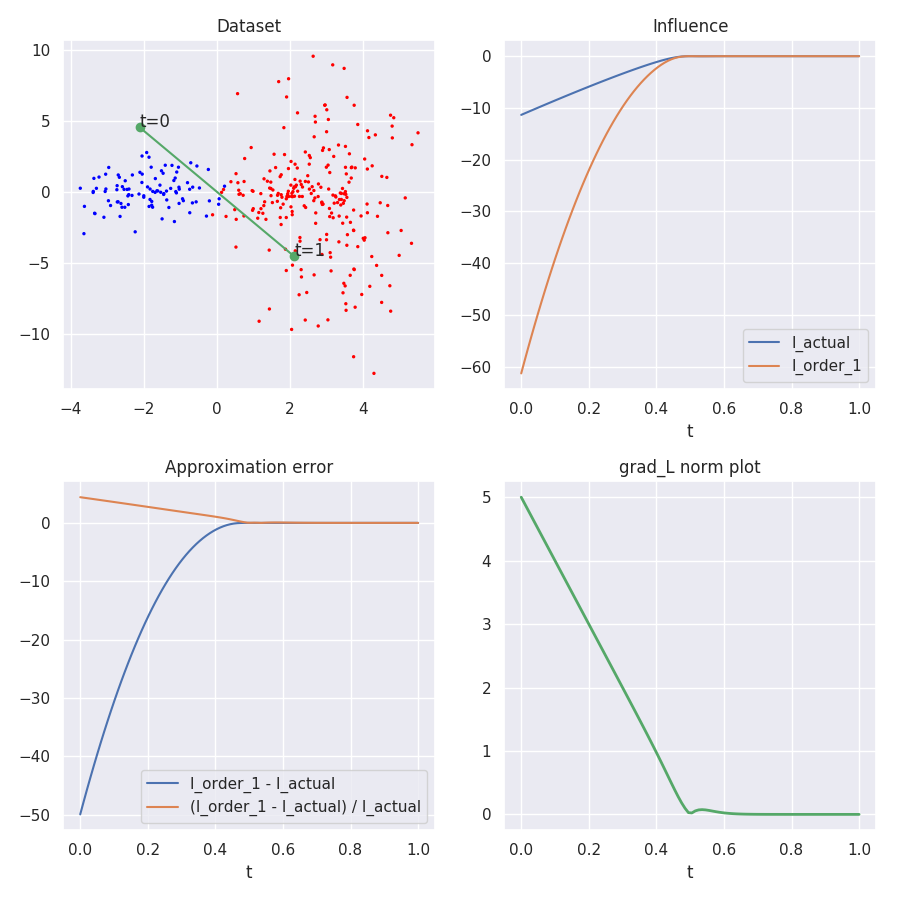

In [29]:
X_sample, y_sample, samples = sample_line(X, y)
plot_variation_2d(X, y, X_sample, y_sample, samples)

- Sanity check: grad L is in the direction of the point, as expected.
- Both 1st and 2nd order influence are larger when adding the positive point on the wrong side of the boundary
- Both 1st and 2nd order approximation error are worse when adding the positive point on the wrong side of the boundary
- Approximation error does not scale proportionally with influence

Higher separation?

<IPython.core.display.Javascript object>


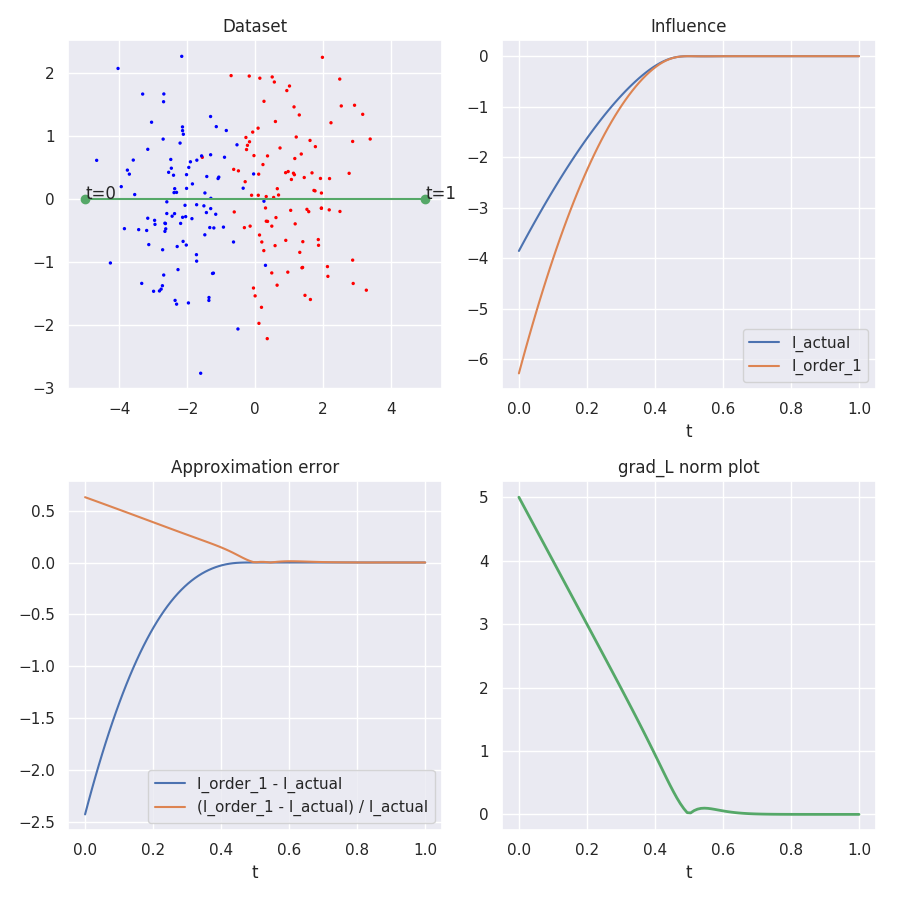

In [30]:
X, y = generate_gaussian_mixture(200, 2, separation=3)
X_0, X_1 = np.array([-5, 0]), np.array([5, 0])
X_sample, y_sample, samples = sample_line(X, y, X_0, X_1)
plot_variation_2d(X, y, X_sample, y_sample, samples)

<IPython.core.display.Javascript object>


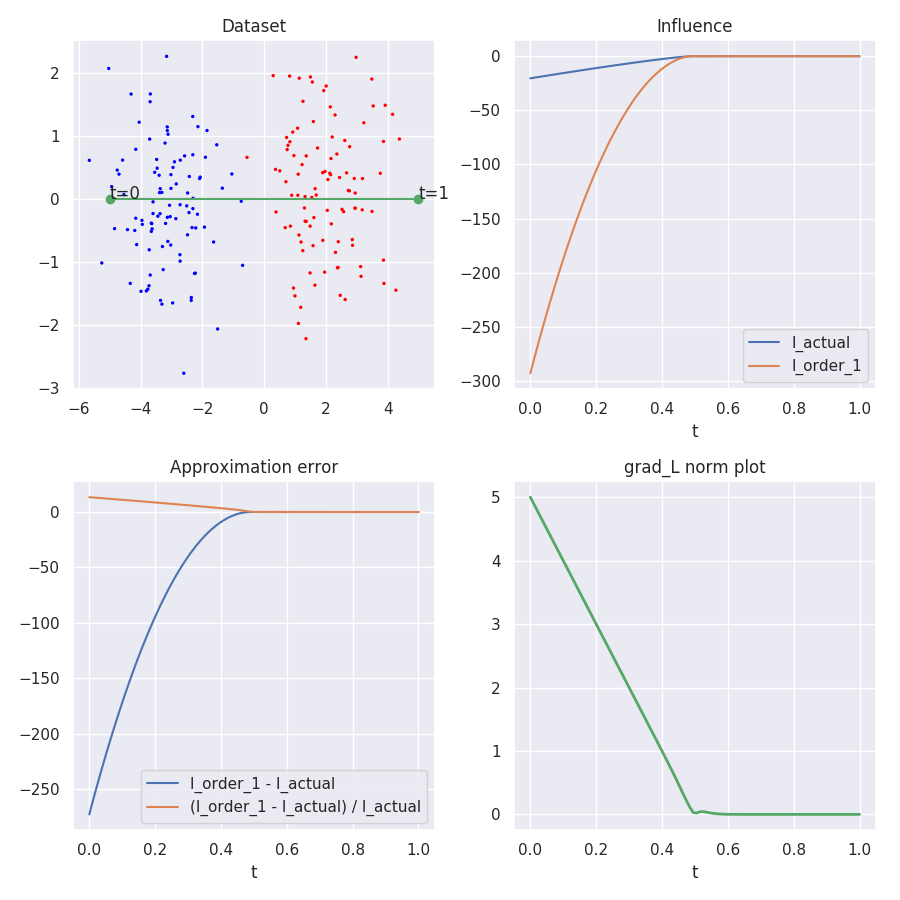

In [31]:
X, y = generate_gaussian_mixture(200, 2, separation=5)
X_0, X_1 = np.array([-5, 0]), np.array([5, 0])
X_sample, y_sample, samples = sample_line(X, y, X_0, X_1)
plot_variation_2d(X, y, X_sample, y_sample, samples)

- Influence decreases with separation, but approximation error doesn't really change much, so relative approximation error increases

# Heatmap

In [15]:
def sample_grid(X, y, grid_bounds=[[-8,8],[-8,8]], grid_samples=[50,50]):
    N, D = X.shape
    
    NX, NY = grid_samples
    grid_X = np.linspace(grid_bounds[0][0], grid_bounds[0][1], grid_samples[0])
    grid_Y = np.linspace(grid_bounds[1][0], grid_bounds[1][1], grid_samples[1])
    grid_X, grid_Y = np.meshgrid(grid_X, grid_Y)
    X_sample = np.vstack((((grid_X[:-1, :-1] + grid_X[1:, 1:]) / 2).reshape(-1),
                          ((grid_Y[:-1, :-1] + grid_Y[1:, 1:]) / 2).reshape(-1))).T
    y_sample = np.full(X_sample.shape[0], 1)
    
    samples = self_influence(X, y, X_sample, y_sample)
    I_actual, I_order_1, I_order_2, grad_L_sample = samples
    I_actual = I_actual.reshape(NX - 1, NY - 1)
    I_order_1 = I_order_1.reshape(NX - 1, NY - 1)
    I_order_2 = I_order_2.reshape(NX - 1, NY - 1)
    grad_L_sample = grad_L_sample.reshape(NX - 1, NY - 1, -1)
    samples = I_actual, I_order_1, I_order_2, grad_L_sample
    
    return grid_X, grid_Y, X_sample, y_sample, samples

In [16]:
def plot_heatmap_2d(X, y, grid_X, grid_Y, X_sample, y_sample, samples):
    I_actual, I_order_1, I_order_2, grad_L_sample = samples
    
    fig, axs = plt.subplots(2, 2, figsize=(9,9))
    cmap = sns.cubehelix_palette(dark=.9, light=.2, as_cmap=True)
    
    def plot_heatmap(ax, value, title):
        c = ax.pcolormesh(grid_X, grid_Y, value)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.get_cmap('bwr'), s=2)
        fig.colorbar(c, ax=ax)
        ax.set_title(title)
    
    def plot_infl(ax):
        vmax = np.abs(I_actual.reshape(-1)).max()
        ax.scatter(I_actual.reshape(-1), I_order_1.reshape(-1))
        ax.plot([-vmax, vmax], [-vmax, vmax])
        ax.set_title("Predicted over actual")
    
    plot_heatmap(axs[0][0], I_actual, 'Actual Influence')
    plot_heatmap(axs[0][1], I_order_1 - I_actual, 'Approximation error')
    plot_infl(axs[1][0])
    #plot_heatmap(axs[1][0], np.linalg.norm(grad_L_sample, axis=2), 'grad L norm')
    plot_heatmap(axs[1][1], np.abs(I_order_1 - I_actual) / (np.abs(I_actual) + 1e-6), 'Rel. approx. error')
    plt.tight_layout()

<IPython.core.display.Javascript object>


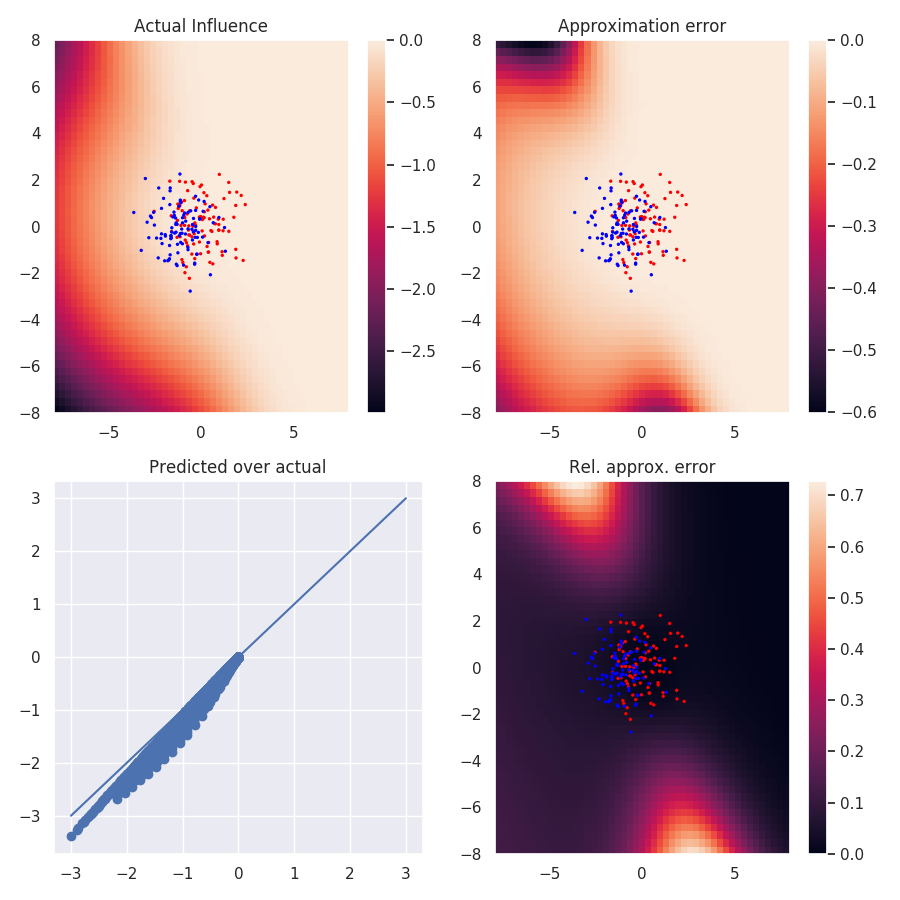

In [17]:
X, y = generate_gaussian_mixture(200, 2)
grid_X, grid_Y, X_sample, y_sample, samples = sample_grid(X, y)
plot_heatmap_2d(X, y, grid_X, grid_Y, X_sample, y_sample, samples)

<IPython.core.display.Javascript object>


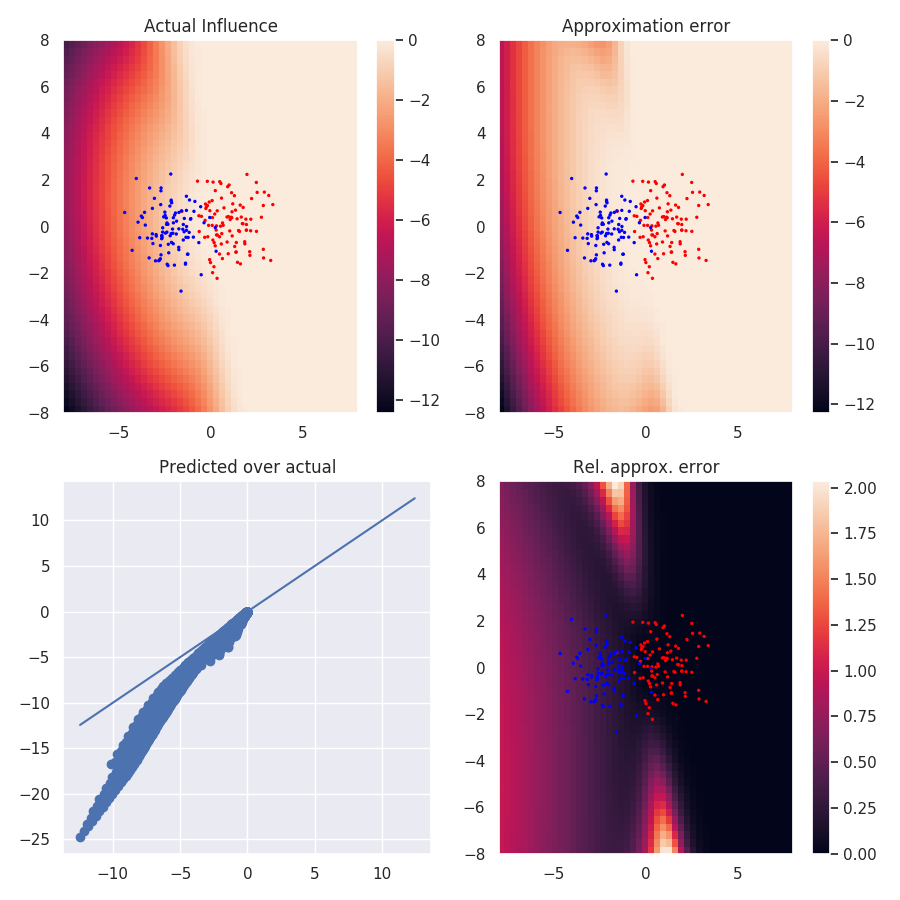

In [18]:
X, y = generate_gaussian_mixture(200, 2, separation=3)
grid_X, grid_Y, X_sample, y_sample, samples = sample_grid(X, y)
plot_heatmap_2d(X, y, grid_X, grid_Y, X_sample, y_sample, samples)

- Approximation error is highest the further away from the boundary on the wrong side of the class, i.e. when the point would be more wrongly classified.
- Relative approximation error is highest on the boundary but far away from the data.

# Other datasets?

In [19]:
def generate_multiple_gaussian_mixtures(gaussians):
    X, y = [], []
    for mean, scale, label, samples in gaussians:
        D = len(mean)
        X.append(np.random.normal(0, 1, (samples, len(mean))) * scale + mean)
        y.append(np.full(samples, label))
    return np.vstack(X), np.hstack(y)

<IPython.core.display.Javascript object>


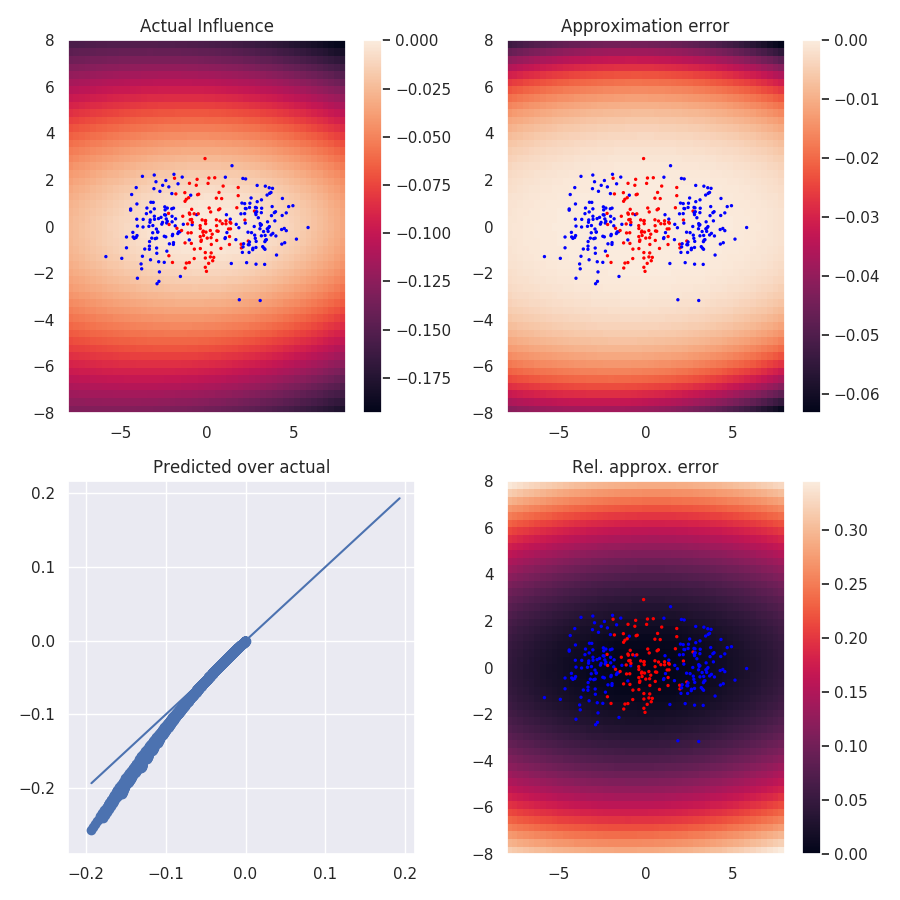

In [20]:
X, y = generate_multiple_gaussian_mixtures([(np.array([-3, 0]), np.array([1, 1]), -1, 100),
                                            (np.array([0, 0]), np.array([1, 1]), 1, 100),
                                            (np.array([3, 0]), np.array([1, 1]), -1, 100)])
grid_X, grid_Y, X_sample, y_sample, samples = sample_grid(X, y)
plot_heatmap_2d(X, y, grid_X, grid_Y, X_sample, y_sample, samples)

<IPython.core.display.Javascript object>


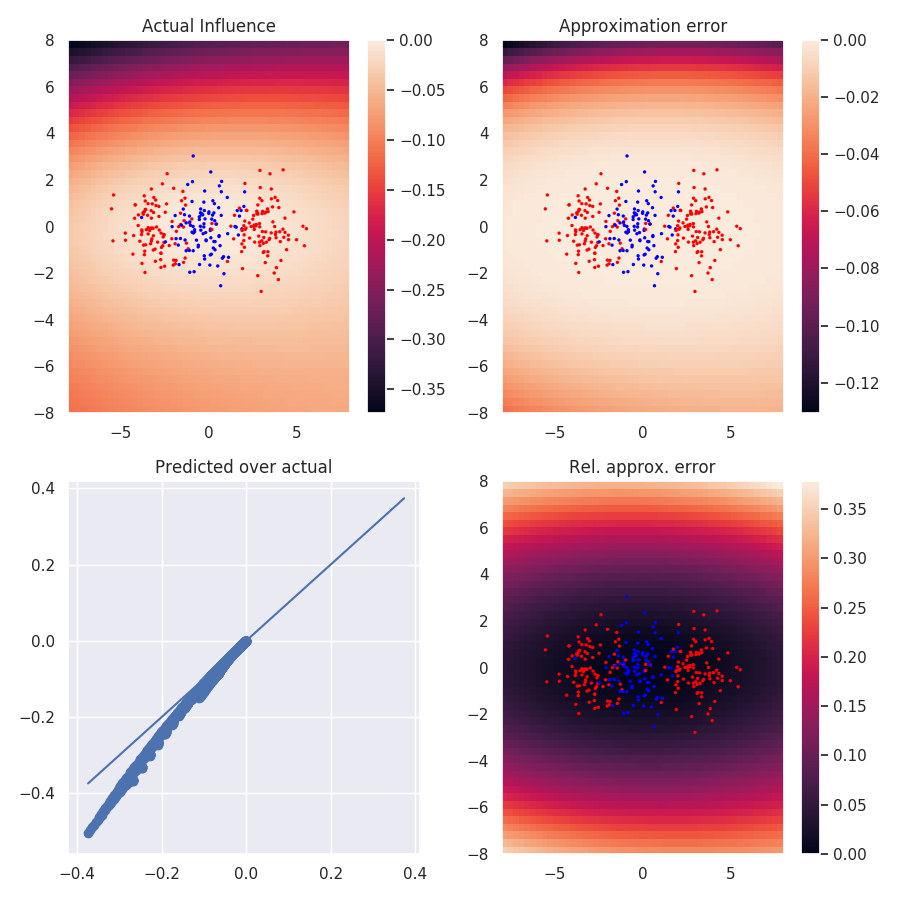

In [21]:
X, y = generate_multiple_gaussian_mixtures([(np.array([-3, 0]), np.array([1, 1]), 1, 100),
                                            (np.array([0, 0]), np.array([1, 1]), -1, 100),
                                            (np.array([3, 0]), np.array([1, 1]), 1, 100)])
grid_X, grid_Y, X_sample, y_sample, samples = sample_grid(X, y)
plot_heatmap_2d(X, y, grid_X, grid_Y, X_sample, y_sample, samples)

<IPython.core.display.Javascript object>


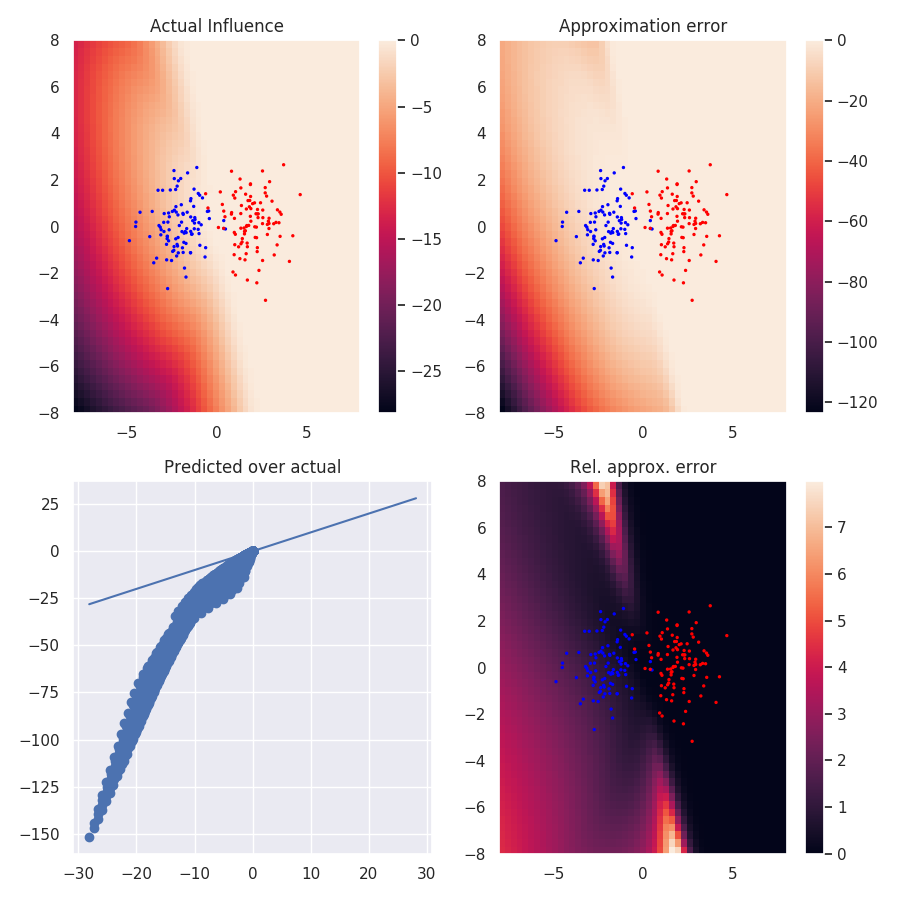

In [22]:
X, y = generate_multiple_gaussian_mixtures([(np.array([-2, 0]), np.array([1, 1]), -1, 100),
                                            (np.array([2, 0]), np.array([1, 1]), 1, 100)])
grid_X, grid_Y, X_sample, y_sample, samples = sample_grid(X, y)
plot_heatmap_2d(X, y, grid_X, grid_Y, X_sample, y_sample, samples)

<IPython.core.display.Javascript object>


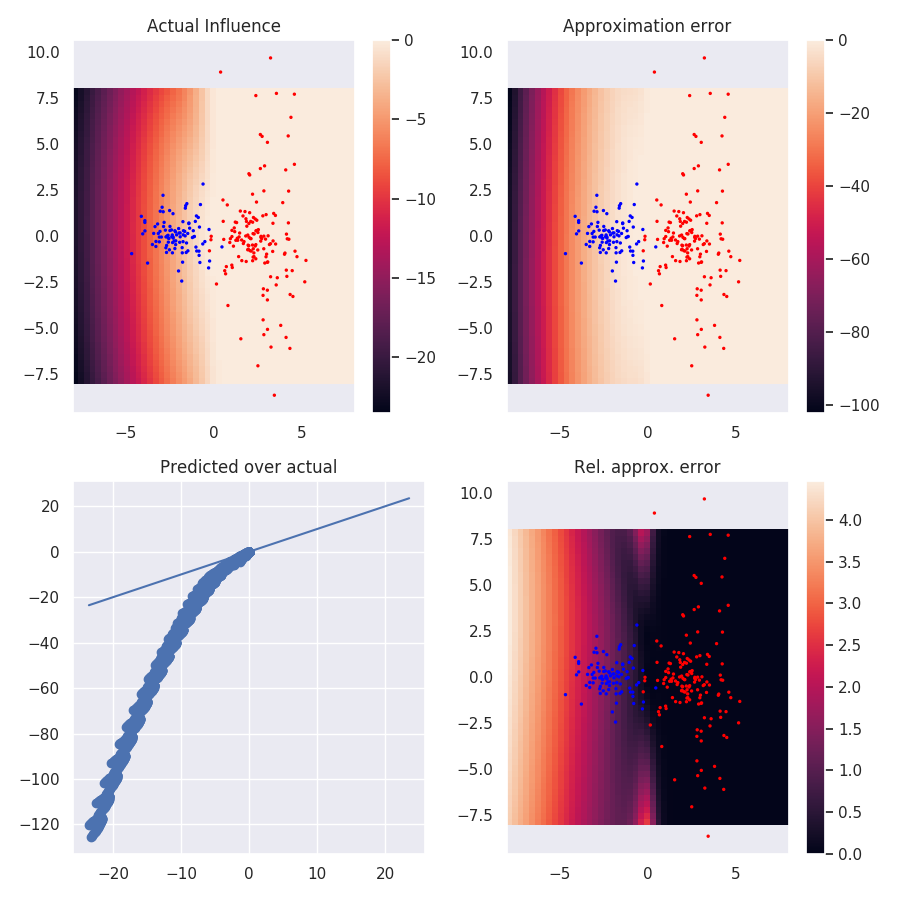

In [23]:
X, y = generate_multiple_gaussian_mixtures([(np.array([-2, 0]), np.array([1, 1]), -1, 100),
                                            (np.array([2, 0]), np.array([1, 1]), 1, 100),
                                            (np.array([3, 0]), np.array([1, 5]), 1, 50)])
grid_X, grid_Y, X_sample, y_sample, samples = sample_grid(X, y)
plot_heatmap_2d(X, y, grid_X, grid_Y, X_sample, y_sample, samples)

<IPython.core.display.Javascript object>


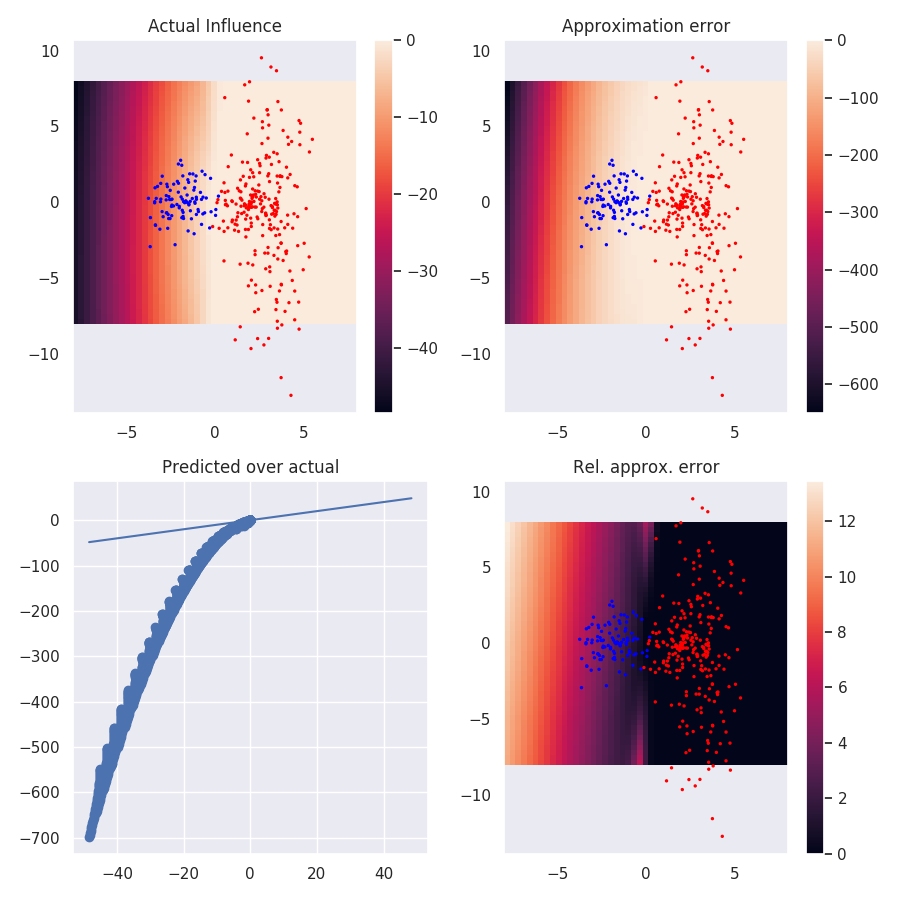

In [24]:
X, y = generate_multiple_gaussian_mixtures([(np.array([-2, 0]), np.array([1, 1]), -1, 100),
                                            (np.array([2, 0]), np.array([1, 1]), 1, 100),
                                            (np.array([3, 0]), np.array([1, 5]), 1, 150)])
grid_X, grid_Y, X_sample, y_sample, samples = sample_grid(X, y)
plot_heatmap_2d(X, y, grid_X, grid_Y, X_sample, y_sample, samples)

- Seems like adding density to regions that make the decision boundary clearer reduces influence and approximation error

# Hessian variation and approximation error

Is the greater relative approximation error around the region of lower confidence due to the Hessian changing more? Let's plot the difference between the original H(theta) and H(theta_hat) after retraining. The influence approximation only uses the Hessian at the original parameters.

In [78]:
def sample_grid_hessians(X, y, grid_bounds=[[-8,8],[-8,8]], grid_samples=[8,8]):
    N, D = X.shape
    
    NX, NY = grid_samples
    grid_X = np.linspace(grid_bounds[0][0], grid_bounds[0][1], grid_samples[0])
    grid_Y = np.linspace(grid_bounds[1][0], grid_bounds[1][1], grid_samples[1])
    grid_X, grid_Y = np.meshgrid(grid_X, grid_Y)
    X_sample = np.vstack((((grid_X[:-1, :-1] + grid_X[1:, 1:]) / 2).reshape(-1),
                          ((grid_Y[:-1, :-1] + grid_Y[1:, 1:]) / 2).reshape(-1))).T
    
    _, _, _, _, orig_theta = train(X, y, None, None)
    _, _, _, _, orig_H = losses_and_hessian(X, y, orig_theta)
    hessians = []
    for x in X_sample:
        Xp = np.vstack((X, x))
        yp = np.hstack((y, 1))
        _, _, _, _, theta = train(Xp, yp, None, None)
        _, _, _, _, hessian = losses_and_hessian(Xp, yp, theta)
        hessians.append(hessian)
    
    return orig_H, X_sample, hessians

In [104]:
def plot_heatmap_hessian(X, y, grid_X, grid_Y, X_sample, y_sample, samples, orig_H, X_hessians, hessians):
    I_actual, I_order_1, I_order_2, grad_L_sample = samples
    
    fig, axs = plt.subplots(2, 1, figsize=(9,18))
    cmap = sns.cubehelix_palette(dark=.9, light=.2, as_cmap=True)
    
    def plot_heatmap(ax, value, title):
        c = ax.pcolormesh(grid_X, grid_Y, value)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.get_cmap('bwr'), s=2)
        fig.colorbar(c, ax=ax)
        ax.set_title(title)
    
    def plot_infl(ax):
        vmax = np.abs(I_actual.reshape(-1)).max()
        ax.scatter(I_actual.reshape(-1), I_order_1.reshape(-1))
        ax.plot([-vmax, vmax], [-vmax, vmax])
        ax.set_title("Predicted over actual")
        
    eigs = [np.linalg.eig(H) for H in hessians + [orig_H]]
    angles = [np.rad2deg(np.arctan2(v[1, 0], v[0, 0])) for _, v in eigs]
    min_eigval = np.min([min(w[0], w[1]) for w, _ in eigs])
    scale = 0.2 / min_eigval
    
    def ellipse(x, w, angle, **kwargs):
        return patches.Ellipse(x, width=w[0], height=w[1], angle=angle, **kwargs)
    
    def plot_ellipses(ax):
        for i, x in enumerate(X_hessians):
            orig_e = ellipse(x, eigs[-1][0] * scale, angles[-1], linewidth=1, fill=None, color='g')
            e = ellipse(x, eigs[i][0] * scale, angles[i], linewidth=1, fill=None, color='b')
            ax.add_patch(orig_e)
            ax.add_patch(e)
    
    plot_heatmap(axs[0], I_order_1 - I_actual, 'Approximation error')
    plot_heatmap(axs[1], np.abs(I_order_1 - I_actual) / (np.abs(I_actual) + 1e-6), 'Rel. approx. error')
    plot_ellipses(axs[0])
    plot_ellipses(axs[1])
    plt.tight_layout()

<IPython.core.display.Javascript object>


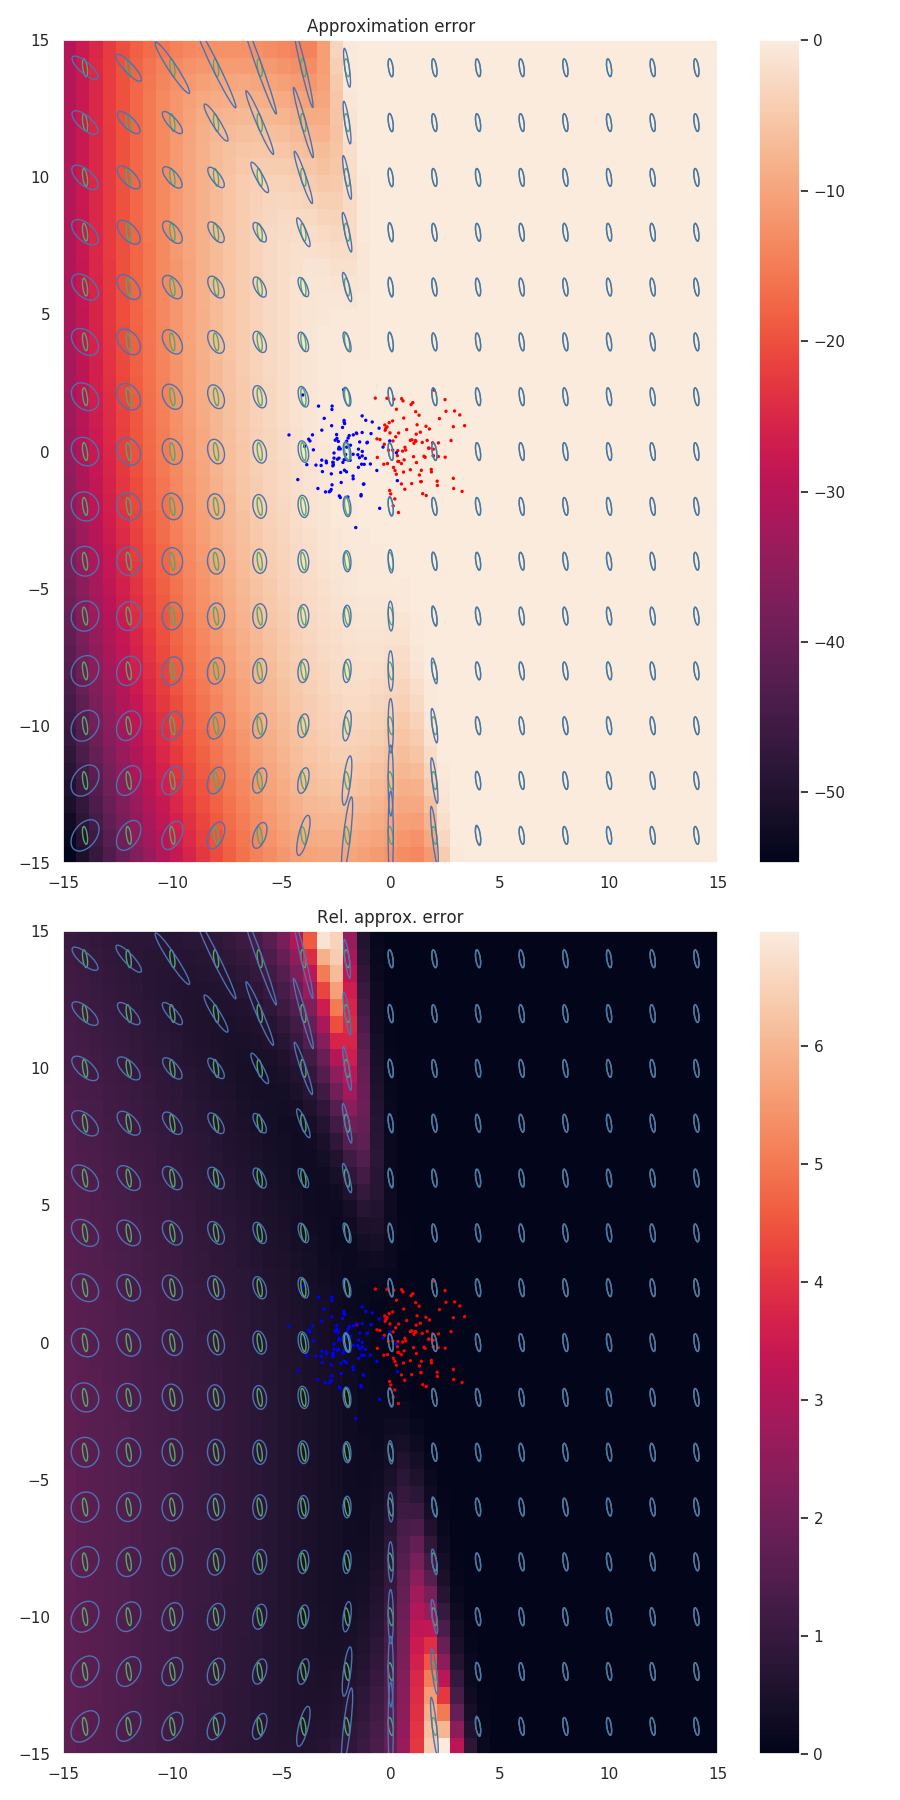

In [105]:
X, y = generate_gaussian_mixture(200, 2, separation=3)
grid_X, grid_Y, X_sample, y_sample, samples = sample_grid(X, y, [[-15, 15], [-15, 15]], [50, 50])
orig_H, X_hessians, hessians = sample_grid_hessians(X, y, [[-15, 15], [-15, 15]], [16, 16])
plot_heatmap_hessian(X, y, grid_X, grid_Y, X_sample, y_sample, samples, orig_H, X_hessians, hessians)